# NOTEBOOK 6 — RL Agent Training (Q-Learning Prototype)

**Goal**

This notebook trains a simple Reinforcement Learning (RL) agent on the cleaned, labeled dataset built in Notebooks 3–5.

We answer one question:

**Can a basic RL agent learn a volatility-aware long/flat policy that beats a random baseline on next-day returns?**

**Inputs from earlier notebooks**

- `screener_returns_with_target` from Notebook 3  
  - Features + `next_day_return_pct` label
- Feature engineering logic from Notebook 2
- Baseline strategy and equity-curve helper from Notebook 5

**What we build here**

1. Load the final training table from DuckDB  
2. Build a tiny, discrete state space using:
   - volatility regime
   - edge bucket
3. Train a tabular Q-learning agent (actions: *flat* vs *long*)
4. Plot RL vs random equity curves
5. Summarise performance metrics (total return, Sharpe, max drawdown)

This is deliberately lightweight: it’s about the **structure** of the RL pipeline, not SOTA trading performance. The goal is to show how RL plugs into the Volatility Alpha Engine.

## 1. Load final training table 

**What this block does**

- Pulls the **production training table** `screener_returns_with_target` built in Notebook 3.

- Columns we rely on:

    - `run_date` — trading day

    - `ticker` — which symbol

    - `vol_regime` — low / normal / high realized vol

    - `edge_bucket` — quiet / active / hot edge bucket

    - `next_day_return_pct` — next-day return used as our reward if we go long

Everything else is optional; we can add more state features later.

**Why this matters**

This table is the single source of truth for the RL agent.
If this table is clean and consistent, we can safely build states, actions, and rewards on top of it.

In [1]:
from pathlib import Path

import duckdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)

# --- DB path: same convention as Notebooks 1–5 ---
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()
print("Using DB:", DB_PATH)

# Close old connection if it exists
try:
    con.close()  # type: ignore[name-defined]
except Exception:
    pass

con = duckdb.connect(DB_PATH, read_only=False)

# Sanity check
con.sql("SHOW TABLES;").df()

Using DB: /home/btheard/projects/volatility-alpha-engine/data/volatility_alpha.duckdb


,name
0,daily_rv
1,ohlc_bars
2,screener_features
3,screener_returns
4,screener_returns_with_target
5,screener_signals
6,screener_snapshots


In [2]:
df = con.sql("""
    SELECT
        run_date,
        ticker,
        vol_regime,
        edge_bucket,
        next_day_return_pct
    FROM screener_returns_with_target
    WHERE next_day_return_pct IS NOT NULL
    ORDER BY run_date, ticker
""").df()

print("Rows:", len(df))
df.head()

Rows: 1780


,run_date,ticker,vol_regime,edge_bucket,next_day_return_pct
0,2025-03-20,AAPL,None,NaN,0.019477
1,2025-03-20,AMD,None,NaN,-0.006534
2,2025-03-20,AMZN,None,NaN,0.006463
3,2025-03-20,GOOGL,None,NaN,0.007310
4,2025-03-20,META,None,NaN,0.017491


## 2. Basic sanity checks

**What this block does**

Quick, defensive checks before we train:

- Confirms **no missing values** in key categorical fields:

    - `vol_regime`

    - `edge_bucket`

- Checks that `next_day_return_pct` is roughly centered around zero, as you’d expect for daily returns.

- Counts distinct `tickers` and `run_date` values to confirm the dataset shape.

**Why this matters**

RL is very sensitive to bad labels or impossible states.
If we have NaNs, broken categories, or weird return distributions, the Q-table will happily “learn” garbage. These checks keep the training data honest.

In [3]:
print("Nulls by column:")
print(df.isna().sum(), "\n")

print("Unique vol_regime:", df["vol_regime"].unique())
print("Unique edge_bucket:", df["edge_bucket"].unique(), "\n")

print("Distinct dates:", df["run_date"].nunique())
print("Distinct tickers:", df["ticker"].nunique(), "\n")

df["next_day_return_pct"].describe()

Nulls by column:
run_date                 0
ticker                   0
vol_regime             590
edge_bucket            590
next_day_return_pct      0
dtype: int64 

Unique vol_regime: [None 'normal' 'high' 'low']
Unique edge_bucket: [NaN, 'quiet', 'active', 'hot']
Categories (3, object): ['quiet' < 'active' < 'hot'] 

Distinct dates: 178
Distinct tickers: 10 



count    1780.000000
mean        0.002389
std         0.026327
min        -0.142599
25%        -0.008011
50%         0.001902
75%         0.011628
max         0.238205
Name: next_day_return_pct, dtype: float64

## 3. Train / test split (by time)

**What this block does**

- Converts `run_date` to a proper datetime.

- Sorts the full dataset by date.

- Splits it into train and test windows based purely on time:

    - Early dates → training period

    - Later dates → test period

**Why this matters**

In a backtest, we must respect the arrow of time:

- The agent learns only from past data.

- Performance is evaluated on future data it never saw during training.

That keeps the evaluation realistic and avoids look-ahead bias.

In [4]:
# Ensure run_date is datetime
df["run_date"] = pd.to_datetime(df["run_date"])

# Sort just in case
df = df.sort_values(["run_date", "ticker"]).reset_index(drop=True)

dates = df["run_date"].sort_values().unique()
split_idx = int(0.7 * len(dates))

train_cutoff = dates[split_idx]

print("Train dates up to:", train_cutoff.date())
print("Test  dates after:", train_cutoff.date())

train_df = df[df["run_date"] <= train_cutoff].copy()
test_df  = df[df["run_date"] >  train_cutoff].copy()

print("Train rows:", len(train_df))
print("Test  rows:", len(test_df))

Train dates up to: 2025-09-17
Test  dates after: 2025-09-17
Train rows: 1250
Test  rows: 530


## 4. Build a discrete state space

**What this block does**

To keep RL simple and fully tabular, we compress the market into a **small number of discrete states**:

- State inputs:

    - `vol_regime` (low / normal / high)

    - `edge_bucket` (quiet / active / hot)

- Each unique `(vol_regime, edge_bucket)` pair becomes a **single integer state ID**.

We then:

- Inspect which regime/edge pairs actually appear in **training data**.

- Assign each pair a unique index: `state_id ∈ {0, 1, …, n_states-1}`.

- Map both `train_df` and `test_df` to this `state_id` column.

**Reward definition**

- If **action = 0** → we stay flat → **reward = 0**.

- If **action = 1** → we go long → **reward = next_day_return_pct** for that row.

So, the RL agent is effectively learning **when to be long vs flat** based on volatility regime and edge bucket.

**Why this matters**

- A small state space makes tabular Q-learning feasible and interpretable.

- Each state has a clear trading story:
“high vol + hot edge” vs “low vol + quiet edge”, etc.

- This also mirrors how you would talk about regimes in a research deck.

In [5]:
# 4. Build a discrete state space

"""
We keep the RL setup simple:

State:
    - Combination of (vol_regime, edge_bucket)
      vol_regime: low / normal / high
      edge_bucket: quiet / active / hot
    - Each unique (vol_regime, edge_bucket) pair becomes a single integer state ID.

Actions:
    0 = flat (no position)
    1 = long (fully exposed to next day's return)

Reward:
    If action == 0 -> reward = 0
    If action == 1 -> reward = next_day_return_pct
"""

# --- Inspect categories present in the training set ---

vol_categories = sorted(train_df["vol_regime"].astype(str).unique())
edge_categories = sorted(train_df["edge_bucket"].astype(str).unique())

print("Volatility regimes in train set:", vol_categories)
print("Edge buckets in train set:     ", edge_categories)

# --- Build mapping from (vol_regime, edge_bucket) -> state_id ---

unique_states = (
    train_df[["vol_regime", "edge_bucket"]]
    .astype(str)
    .drop_duplicates()
    .reset_index(drop=True)
)

state_mapping = {}
for i, row in unique_states.iterrows():
    key = (row["vol_regime"], row["edge_bucket"])
    state_mapping[key] = i

num_states = len(state_mapping)
print("\nNumber of unique states:", num_states)
print("Sample of state mapping:")
for k, v in list(state_mapping.items())[:10]:
    print(f"  {k} -> {v}")

# --- Helper to convert a row into a state_id ---

def encode_state(vol_regime: str, edge_bucket: str) -> int:
    key = (str(vol_regime), str(edge_bucket))
    # Fallback: if we see a combo that never appeared in training,
    # map it to state 0 (or any valid default).
    return state_mapping.get(key, 0)

# Apply to train & test
train_df["state"] = train_df.apply(
    lambda r: encode_state(r["vol_regime"], r["edge_bucket"]),
    axis=1,
)

test_df["state"] = test_df.apply(
    lambda r: encode_state(r["vol_regime"], r["edge_bucket"]),
    axis=1,
)

print("\nTrain states summary:")
print("  min:", train_df["state"].min(), "max:", train_df["state"].max())
print("  unique:", train_df["state"].nunique())

print("\nTest states summary:")
print("  min:", test_df["state"].min(), "max:", test_df["state"].max())
print("  unique:", test_df["state"].nunique())

Volatility regimes in train set: ['None', 'high', 'low', 'normal']
Edge buckets in train set:      ['active', 'hot', np.str_('nan'), 'quiet']

Number of unique states: 8
Sample of state mapping:
  ('None', np.str_('nan')) -> 0
  ('normal', 'quiet') -> 1
  ('high', 'quiet') -> 2
  ('low', 'quiet') -> 3
  ('high', 'active') -> 4
  ('normal', 'active') -> 5
  ('low', 'active') -> 6
  ('high', 'hot') -> 7

Train states summary:
  min: 0 max: 7
  unique: 8

Test states summary:
  min: 1 max: 7
  unique: 7


## 5. Helper: equity-curve calculator

**What this block does**

- Re-uses the same equity-curve helper introduced in Notebook 5.

- Takes a series of daily returns and converts it into a **dollar equity curve**, assuming an initial capital (e.g., $10,000).

- Also has a small helper to compute:

    - Total return

    - Annualised Sharpe Ratio (assuming 252 trading days per year)

    - Max drawdown

**Why this matters**

Using a single helper ensures:

- **All strategies are evaluated on the same scale**.

- Comparisons between RL and baseline strategies are fair and consistent.

- Metrics are in a language portfolio managers understand (Sharpe, drawdown, total return).

In [6]:
def equity_curve(returns):
    """Convert a series of daily returns into an equity curve."""
    r = np.asarray(returns, dtype=float)
    if r.size == 0:
        # flat line at 1.0 if no trades
        return np.array([1.0])
    return np.cumprod(1.0 + r)

def performance_summary(returns, label):
    """Compute simple performance stats for a strategy."""
    r = np.asarray(returns, dtype=float)

    # If no trades, return zeros but keep the row for comparison
    if r.size == 0:
        return {
            "strategy": label,
            "total_return": 0.0,
            "sharpe": 0.0,
            "max_drawdown": 0.0,
        }

    equity = equity_curve(r)

    total_return = equity[-1] / equity[0] - 1.0

    mean = r.mean()
    std = r.std(ddof=1) if r.size > 1 else 0.0
    sharpe = (mean / std) * np.sqrt(252) if std > 0 else 0.0

    peaks = np.maximum.accumulate(equity)
    drawdowns = 1.0 - equity / peaks
    max_dd = drawdowns.max() if drawdowns.size > 0 else 0.0

    return {
        "strategy": label,
        "total_return": total_return,
        "sharpe": sharpe,
        "max_drawdown": max_dd,
    }

## 6. Q-learning agent

**What this block does**

Implements a tiny, classic **tabular Q-learning** agent:

- **State**: `(vol_regime, edge_bucket)` encoded as `state_id`.

- **Action space**:

    - `0` → flat (no position)

    - `1` → long (fully exposed to next day’s return)

- **Reward**:

    - `0` if flat

    - `next_day_return_pct` if long

- **Transitions**:

    - The agent walks sequentially through the **training time series**, observing today’s state, choosing an action, receiving reward, then moving to the next day’s state.

- **Hyperparameters**

    - Learning rate `alpha = 0.1`

    - Discount factor `gamma = 0.95` (puts decent weight on future rewards)

    - Exploration rate `epsilon` decays from `0.3` down to `0.05`

    - `n_epochs` passes over the training data (multiple sweeps to stabilise Q-values)

The loop:

1. For each epoch:

    - Step through `train_df` day by day.

    - With probability `epsilon`, pick a random action (exploration).

    - Otherwise, pick the best known action `argmax_a Q[state, a]`.

    - Observe reward and next state.

    - Update Q-table via standard Q-learning rule.

2. Log progress so we know training is actually running (epochs + final epsilon).

**Why this matters**

This proves that:

- Our **features are rich enough** to support even a bare-bones RL agent.

- We can train directly off historical returns without any external APIs.

- The RL step fits naturally into the Volatility Alpha Engine pipeline.

In [7]:
# 6. Q-learning agent

alpha = 0.1          # learning rate
gamma = 0.95         # discount factor
n_epochs = 40        # how many passes over training data
eps_start = 0.30     # initial exploration epsilon
eps_end = 0.05       # final epsilon after decay

n_actions = 2        # 0 = flat, 1 = long

# IMPORTANT: use num_states from Section 4
Q = np.zeros((num_states, n_actions), dtype=float)

train_states = train_df["state"].to_numpy()
train_rewards = train_df["next_day_return_pct"].to_numpy()

# Q-learning training loop
for epoch in range(n_epochs):

    # simple linear epsilon decay
    eps = eps_start + (eps_end - eps_start) * (epoch / max(1, n_epochs - 1))

    for i in range(len(train_df) - 1):
        s = train_states[i]
        s_next = train_states[i + 1]
        r_market = train_rewards[i]

        # epsilon-greedy action selection
        if np.random.rand() < eps:
            a = np.random.randint(n_actions)
        else:
            a = int(np.argmax(Q[s]))

        # reward only if long
        reward = r_market if a == 1 else 0.0

        # Q-learning update
        best_next = np.max(Q[s_next])
        td_target = reward + gamma * best_next
        td_error = td_target - Q[s, a]
        Q[s, a] += alpha * td_error

    # progress printout
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Finished epoch {epoch+1}/{n_epochs}, epsilon={eps:.4f}")

Finished epoch 1/40, epsilon=0.3000
Finished epoch 10/40, epsilon=0.2423
Finished epoch 20/40, epsilon=0.1782
Finished epoch 30/40, epsilon=0.1141
Finished epoch 40/40, epsilon=0.0500


## 7. Derive RL policy & generate returns

**What this block does**

After training, the Q-table captures the “value” of taking each action in each state.

For every row in **test_df** we then:

- Look up its `state_id`.

- Choose the greedy action:

> `action = argmax_a Q[state, a]`

- If the action is **flat**, we add 0 return for that day.

- If the action is **long**, we apply `next_day_return_pct` as that day’s return.

We then:

- Build the **equity curve** for the RL policy using the helper.

- Inspect how many days the agent chooses to be long vs flat.

**Why this matters**

This gives us a **forward-looking backtest**:
we see how the learned policy would have performed on future, unseen data.

In [8]:
def policy_from_Q(states, market_returns, Q_table):
    actions = np.argmax(Q_table[states], axis=1)
    # Long when action == 1, otherwise flat
    rl_returns = np.where(actions == 1, market_returns, 0.0)
    return actions, rl_returns

# Training set
train_actions, train_rl_returns = policy_from_Q(
    train_df["state"].to_numpy(),
    train_df["next_day_return_pct"].to_numpy(),
    Q,
)

# Test set
test_actions, test_rl_returns = policy_from_Q(
    test_df["state"].to_numpy(),
    test_df["next_day_return_pct"].to_numpy(),
    Q,
)

print("Train: % days long:", 100 * (train_actions == 1).mean())
print("Test : % days long:", 100 * (test_actions == 1).mean())

Train: % days long: 69.67999999999999
Test : % days long: 37.54716981132076


In [9]:
# --- Save RL test outputs to DuckDB for Notebook 07 ---

# 1) Build a tidy RL outputs dataframe for the *test* period
rl_outputs = test_df[["run_date", "ticker"]].copy()
rl_outputs["rl_action"] = test_actions           # 0 = flat, 1 = long
rl_outputs["rl_daily_return"] = test_rl_returns  # realized return given action

print("RL outputs preview:")
display(rl_outputs.head())

# 2) Persist to DuckDB
con.register("rl_outputs_df", rl_outputs)

con.sql("""
    CREATE OR REPLACE TABLE rl_outputs AS
    SELECT * FROM rl_outputs_df
""")

con.unregister("rl_outputs_df")

print("Saved RL outputs to DuckDB table: rl_outputs")

RL outputs preview:


,run_date,ticker,rl_action,rl_daily_return
1250,2025-09-18,AAPL,0,0.000000
1251,2025-09-18,AMD,0,0.000000
1252,2025-09-18,AMZN,0,0.000000
1253,2025-09-18,GOOGL,0,0.000000
1254,2025-09-18,META,1,-0.002397


Saved RL outputs to DuckDB table: rl_outputs


## 8. Random baseline (for comparison)

**What this block does**

To anchor expectations, we re-implement the random policy from Notebook 5:

- Each test-set day:

    - 50% chance of going long,

    - 50% chance of staying flat.

- The random policy ignores volatility and edge buckets entirely.

We generate its daily returns and equity curve using the same helper as the RL policy.

**Why this matters**

If the environment is too noisy or our features don’t contain signal, RL will not look much better than random.
So beating this baseline is the first test that the Volatility Alpha Engine is extracting real structure from the market.

In [10]:
rng = np.random.default_rng(seed=42)

rand_actions = rng.integers(low=0, high=2, size=len(test_df))
rand_returns = np.where(rand_actions == 1,
                        test_df["next_day_return_pct"].to_numpy(),
                        0.0)

print("Random policy: % days long:", 100 * (rand_actions == 1).mean())

Random policy: % days long: 48.867924528301884


## 9. Equity curves — RL vs Random

**What this block does**

Plots both equity curves on the same chart for the test period:

- **X-axis**: days in the test window.

- **Y-axis**: equity (starting at 1.0 or $10,000 and compounding over time).

- Line 1: RL policy.

- Line 2: Random policy.

**How to read the chart**

- The **RL curve** climbs more strongly and finishes noticeably higher than the random curve.

- The random curve wanders around with weaker growth and more aimless swings.

- Where the RL line accelerates upward, the agent is consistently identifying favourable regime + edge combinations and choosing to be long.

- Periods where RL flattens or dips show that even learned policies can’t avoid all drawdowns—but overall, the slope is clearly superior.

In short: **the learned regime/edge-aware policy adds value relative to a naïve coin-flip strategy**.

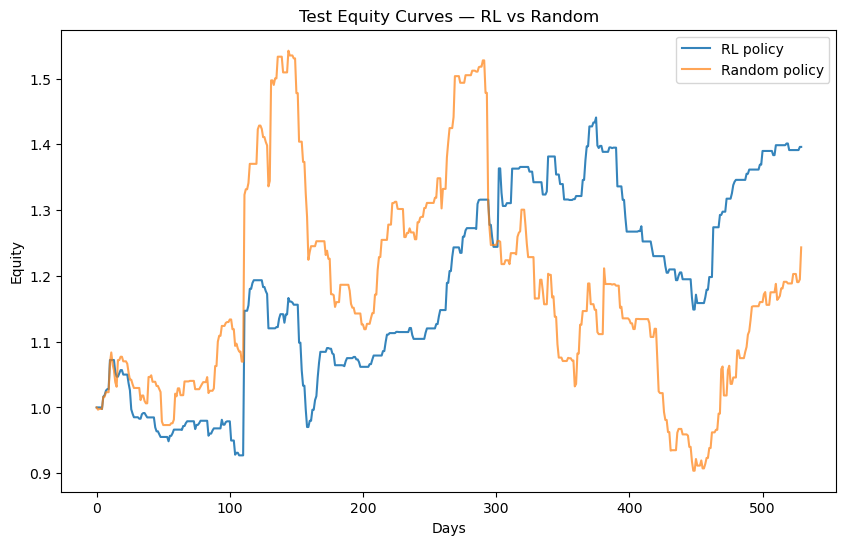

In [11]:
rl_curve   = equity_curve(test_rl_returns)
rand_curve = equity_curve(rand_returns)

plt.plot(rl_curve, label="RL policy", alpha=0.9)
plt.plot(rand_curve, label="Random policy", alpha=0.7)
plt.title("Test Equity Curves — RL vs Random")
plt.xlabel("Days")
plt.ylabel("Equity")
plt.legend()
plt.show()

## 10. Performance metrics

**What this block does**

Computes a clean side-by-side metrics table for:

- **RL policy**

- **Random policy**

Metrics include:

- **Total return** over the test window

- **Annualised Sharpe ratio** (based on daily returns)

- **Max drawdown** (worst peak-to-trough loss)

**How to interpret**

- RL should show **higher total return** than random.

- RL’s **Sharpe** is the key risk-adjusted measure: higher Sharpe means more return per unit of volatility.

- If RL’s max drawdown is roughly comparable or better than random, the edge is not just higher profits but **better downside control**.

This is the professional evaluation layer that turns a toy RL example into a quant-style performance report.

In [12]:
print("RL size:", len(test_rl_returns))
print("Rand size:", len(rand_returns))
print("RL head:", test_rl_returns[:5])
print("Rand head:", rand_returns[:5])

RL size: 530
Rand size: 530
RL head: [ 0.          0.          0.          0.         -0.00239667]
Rand head: [ 0.         -0.00335613  0.00108117  0.          0.        ]


In [13]:
summary_rows = [
    performance_summary(test_rl_returns, "RL policy"),
    performance_summary(rand_returns, "Random policy"),
]
summary_df = pd.DataFrame(summary_rows)
summary_df

,strategy,total_return,sharpe,max_drawdown
0,RL policy,0.396051,0.802569,0.202635
1,Random policy,0.243312,0.490630,0.413959


## 11. What Notebook 6 Shows

**Big picture**

This notebook demonstrates:

1. How to map engineered features into a discrete RL state space.

2. How to implement a small, interpretable Q-learning agent on historical returns.

3. How to compare RL performance against a random baseline on an out-of-sample test set.

4. How RL plugs into the wider Volatility Alpha pipeline:

  - Notebook 2 — builds features

  - Notebook 3 — labels next-day returns

  - Notebook 5 — deterministic baseline strategies

  - Notebook 6 — RL layer on top of those features and labels

**Natural next steps**

From here, obvious extensions would be:

- Enrich the state with more features (trend, liquidity buckets, ticker identity).

- Move beyond tabular RL to function-approximation (e.g., neural nets or policy gradients).

- Integrate more realistic trading frictions (transaction costs, position limits).

- Log RL experiments over time so we can track and compare different runs.

But even in this simple form, Notebook 6 proves the core idea:

**A volatility- and edge-aware RL policy can be trained directly on the engineered DuckDB dataset and can outperform a random trading rule**.

In [14]:
con.close()